In [1]:
!git clone --depth 1 https://github.com/spMohanty/PlantVillage-Dataset.git

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163214, done.
remote: Counting objects: 100% (163214/163214), done.
remote: Compressing objects: 100% (163119/163119), done.
remote: Total 163214 (delta 93), reused 163211 (delta 93), pack-reused 0 (from 0)
Receiving objects: 100% (163214/163214), 2.00 GiB | 30.71 MiB/s, done.
Resolving deltas: 100% (93/93), done.
Updating files: 100% (182401/182401), done.


In [2]:
import os

dataset_path = "PlantVillage-Dataset/raw/color"
classes = os.listdir(dataset_path)
print(f"Total classes: {len(classes)}")
print(classes)

Total classes: 38
['Potato___Late_blight', 'Pepper,_bell___healthy', 'Tomato___Tomato_mosaic_virus', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Apple___Cedar_apple_rust', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Blueberry___healthy', 'Squash___Powdery_mildew', 'Soybean___healthy', 'Grape___healthy', 'Pepper,_bell___Bacterial_spot', 'Raspberry___healthy', 'Strawberry___healthy', 'Peach___Bacterial_spot', 'Corn_(maize)___healthy', 'Tomato___Early_blight', 'Corn_(maize)___Northern_Leaf_Blight', 'Potato___Early_blight', 'Cherry_(including_sour)___Powdery_mildew', 'Tomato___healthy', 'Cherry_(including_sour)___healthy', 'Peach___healthy', 'Apple___Apple_scab', 'Apple___healthy', 'Corn_(maize)___Common_rust_', 'Potato___healthy', 'Grape___Esca_(Black_Measles)', 'Tomato___Late_blight', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Septoria_leaf_spot', 'Tomato___Leaf_Mold', 'Apple___Black_rot', 'Tomato___Tomato_Ye

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import os

# Enable CuDNN optimizations
torch.backends.cudnn.benchmark = True

# Define transforms (smaller image size: 128×128)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Reduced image size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset_path = "PlantVillage-Dataset/raw/color"  # Modify path in Kaggle
dataset = ImageFolder(root=dataset_path, transform=transform)

# Split dataset: 60% Train, 20% Validation, 20% Test
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Use smaller batch size
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Check dataset class labels
class_names = dataset.classes
print(f"Total classes: {len(class_names)}")
print(class_names)

Total classes: 38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', '

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the trained VGG16 model
model = models.vgg16(pretrained=True)
num_ftrs = model.classifier[6].in_features
num_classes = 38  # Number of classes in the dataset
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

# Freeze convolutional layers
for param in model.features.parameters():
    param.requires_grad = False

# Move model to device
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)  # Train only classifier

# Enable Mixed Precision Training
scaler = torch.amp.GradScaler()

# DataLoader optimizations
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Training setup
num_epochs = 10
train_acc_history = []
val_acc_history = []
test_acc_history = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    loop = tqdm(train_loader, leave=True, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type="cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=f"{running_loss / len(train_loader):.4f}", acc=f"{100 * correct / total:.2f}%")

# Save the trained model
torch.save(model.state_dict(), "vgg16_trained.pth")
print("\n🚀 Model saved as vgg16_trained.pth")

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 224MB/s]
Epoch 10/10: 100%|██████████| 1019/1019 [00:56<00:00, 18.01it/s, acc=98.15%, loss=0.0649]



🚀 Model saved as vgg16_trained.pth


In [5]:
import numpy as np
import torch

# Function to calculate per-class accuracy for different datasets
def calculate_per_class_accuracy(model, data_loaders, device, datasets=["Training", "Validation", "Test"]):
    for dataset_type, data_loader in zip(datasets, data_loaders):
        model.eval()
        class_correct = np.zeros(num_classes)
        class_total = np.zeros(num_classes)

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                for i in range(len(labels)):
                    label = labels[i].item()
                    class_correct[label] += (predicted[i] == label).item()
                    class_total[label] += 1

        # Print per-class accuracy for the current dataset
        print(f"\n📊 Final Per-Class {dataset_type} Accuracy:\n")
        for i in range(num_classes):
            accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
            print(f"{class_names[i]}: {dataset_type} = {accuracy:.2f}%")


# ---------- Calculate Per-Class Accuracy for Training, Validation, and Test Data ----------
# List of data loaders for training, validation, and test datasets
data_loaders = [train_loader, val_loader, test_loader]

# List of dataset names
datasets = ["Training", "Validation", "Test"]

# Call the function for calculating accuracy
calculate_per_class_accuracy(model, data_loaders, device, datasets=datasets)



📊 Final Per-Class Training Accuracy:

Apple___Apple_scab: Training = 100.00%
Apple___Black_rot: Training = 100.00%
Apple___Cedar_apple_rust: Training = 100.00%
Apple___healthy: Training = 99.90%
Blueberry___healthy: Training = 100.00%
Cherry_(including_sour)___Powdery_mildew: Training = 100.00%
Cherry_(including_sour)___healthy: Training = 99.81%
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: Training = 99.68%
Corn_(maize)___Common_rust_: Training = 100.00%
Corn_(maize)___Northern_Leaf_Blight: Training = 98.06%
Corn_(maize)___healthy: Training = 100.00%
Grape___Black_rot: Training = 99.47%
Grape___Esca_(Black_Measles): Training = 99.88%
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): Training = 100.00%
Grape___healthy: Training = 100.00%
Orange___Haunglongbing_(Citrus_greening): Training = 100.00%
Peach___Bacterial_spot: Training = 100.00%
Peach___healthy: Training = 98.05%
Pepper,_bell___Bacterial_spot: Training = 97.52%
Pepper,_bell___healthy: Training = 100.00%
Potato___Early_blig

✅ Test Accuracy: 95.73%


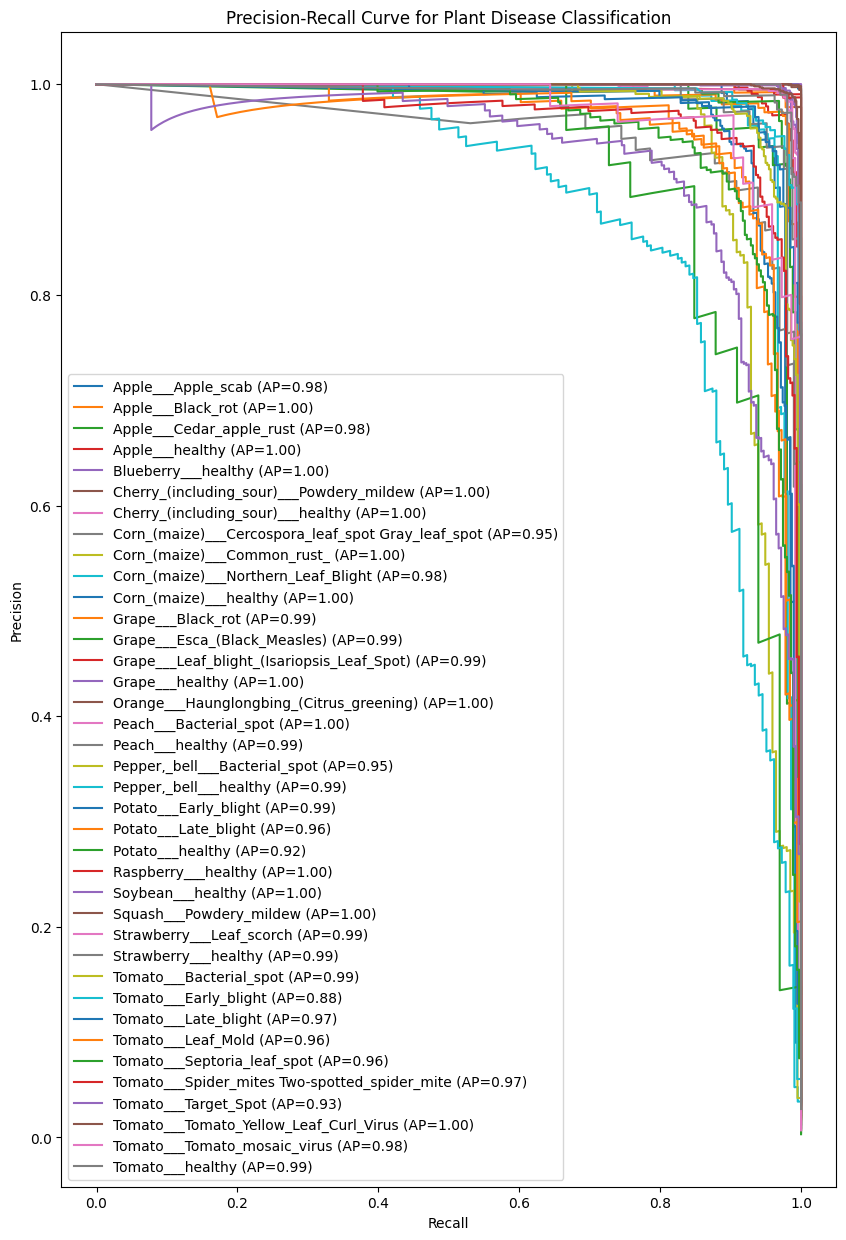

In [6]:
import numpy as np
import torch
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Initialize lists for storing true labels and predicted probabilities
y_true = []
y_scores = []

# Switch to evaluation mode
model.eval()

# Test Accuracy and collect predictions
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"✅ Test Accuracy: {test_acc:.2f}%")

# Collect true labels and predicted probabilities for PR Curve
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

# Convert lists to numpy arrays for PR curve calculation
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Plot Precision-Recall curves for each class
plt.figure(figsize=(10, 15))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_true == i, y_scores[:, i])
    avg_precision = average_precision_score(y_true == i, y_scores[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]} (AP={avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Plant Disease Classification")
plt.legend()
plt.show()